In [ ]:
 nome = 'Matheus Lindino'
print(f'Meu nome é {nome}')

Meu nome é Matheus Lindino


## Instruções

- Treinar uma rede neural de duas camadas como classificador binário na tarefa de análise de sentimentos usando dataset IMDB usando TF-IDF como entrada.

Deve-se implementar o laço de treinamento e validação da rede neural.

Neste exercício usaremos o IMDB com 20k exemplos para treino, 5k para desenvolvimento e 25k para teste.

# Importando os pacotes necessários

In [ ]:
import re
import os
import torch
import torch.nn as nn
import random
import collections
import numpy as np

from tqdm import tqdm
from typing import List

# Verificando se a GPU está disponível

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   print(torch. cuda. get_device_name(dev))
else:
   dev = "cpu" 
print(dev)
device = torch.device(dev)

Tesla T4
cuda:0


## Preparando Dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Carregando o dataset

Criaremos uma divisão de treino (80%) e validação (20%) artificialmente.

Nota: Evitar de olhar ao máximo o dataset de teste para não ficar enviseado no que será testado. Em aplicações reais, o dataset de teste só estará disponível no futuro, ou seja, é quando o usuário começa a testar o seu produto.

In [ ]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

n_train = int(0.8 * len(x_train))

x_valid = x_train[n_train:]
y_valid = y_train[n_train:]
x_train = x_train[:n_train]
y_train = y_train[:n_train]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
False If I only had one camera that was accidentally glued to the floor, enough film for only one take of 
False This is even worse than the original Game of Death. A jumbled, incoherent storyline leads to "Billy 
False It is very unfortunate when a movie such as this is made. A great deal of work and money has been pu
3 últimas amostras treino:
True I had pleasure to watch the short film "The Cure", by first time director Ryan Jafri. What really im
True This is almost typical Lynch. However, What makes this film slightly unusual for Lynch is the fact t
False Ok so I was bored and I watched it all the way through.<br /><br />This film is mild, inoffensive an
3 primeiras amostras validação:
True My Take: Makes use of its familiar plot with fine performances and a few genuine moments of exciteme
True To say that Thunderbirds is a horrid, forced, in-your-face, ugly looking, na

## Classe TF-IDF

In [ ]:
from math import log

class TF_IDF():
  def __init__(self, max_tokens: int = 1000):
    self.max_tokens = max_tokens
    self.vocab = {}
    self.idf = {} #torch.empty(max_tokens)

  def fit(self, texts: List[str]):
    # Inspirado em Bruno --> o .fit inicial não era eficaz!
    
    # .fit inicial:
      # tokens = self.tokenize(' '.join(texts))
      # self.vocab = dict(collections.Counter(tokens).most_common(self.max_tokens))
      # N = len(texts)

      # for token in self.vocab.keys():
      #   count = sum([1 for sentence in texts if token in sentence])
      #   self.idf[token] = log(N / (count))

    N = len(texts)
    all_tokens = [self.tokenize(sample) for sample in texts]
    count = []

    for tokens in all_tokens:
      for sample in set(tokens):
        count.append(sample)
    
    count = collections.Counter(count).most_common(self.max_tokens)
    self.idf = {key: np.log(N/value) for key, value in count}

    return self

  def transform(self, sample: str):
    tf = collections.Counter(self.tokenize(sample))
    result = []

    for token in self.idf.keys():
      try:
        result.append(tf[token] * self.idf[token])
      except:
        result.append(0)
    
    return result

  def tokenize(self, text: str): 
    pattern = r'\w+'
    upper_tokens = re.findall(pattern, text)
    return [tokens.lower() for tokens in upper_tokens]

### Testando implementação do TF-IDF

In [ ]:
def tokenize(text: str): 
  upper_tokens = re.findall(r'\w+', text)
  return [tokens.lower() for tokens in upper_tokens]
  

corpus = ['Apple Mango Banana Apple Avocado Pineapple',
          'Apple Pineapple Mango',
          'Banana Mango Banana Apple',
          'Pineapple Berry Apricot Apple',
          'Mango Mango Avocado Apple']

N = len(corpus)
max_tokens = 5

example_1 = 'Pineapple Avocado Apple Apple'
example_2 = 'Apricot Apple Banana Banana Banana'

expected_idf = {'apple': log(N/5), 'mango': log(N/4), 'banana': log(N/2), 'avocado': log(N/2), 'pineapple': log(N/3)}
tf_example_1 = collections.Counter(tokenize(example_1))
tf_example_2 = collections.Counter(tokenize(example_2))

expected_tfidf_example_1 = []
expected_tfidf_example_2 = []
for key, value in expected_idf.items():
  expected_tfidf_example_1.append(expected_idf[key]*tf_example_1[key])
  expected_tfidf_example_2.append(expected_idf[key]*tf_example_2[key])


custom_transform = TF_IDF(max_tokens=max_tokens).fit(corpus)

assert len(custom_transform.idf) == max_tokens, 'Vocab size incorrect'
assert expected_idf['apple'] == custom_transform.idf['apple'], 'IDF not equal'
assert expected_idf['banana'] == custom_transform.idf['banana'], 'IDF not equal'

tf_idf_example_1 = custom_transform.transform(example_1)
tf_idf_example_2 = custom_transform.transform(example_2)


expected_tfidf_example_1.sort()
expected_tfidf_example_2.sort()
tf_idf_example_1.sort()
tf_idf_example_2.sort()

assert expected_tfidf_example_1 == tf_idf_example_1, 'TF-IDF incorrect'
assert expected_tfidf_example_2 == tf_idf_example_2, 'TF-IDF incorrect'

## Criando Dataset customizado

In [ ]:
class CustomDataset(nn.Module):
  def __init__(self, x, y, transform):
    super().__init__()
    self.x = torch.Tensor([transform(sample) for sample in x]).float()
    self.y = torch.Tensor(y).long()

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

### Testando Dataset

In [ ]:
corpus = ['Apple Mango Banana Apple Avocado Pineapple',
          'Apple Pineapple Mango',
          'Banana Mango Banana Apple',
          'Pineapple Berry Apricot Apple',
          'Mango Mango Avocado Apple']
target = [0, 0, 1, 0, 1]

custom_transform = TF_IDF(max_tokens=5).fit(corpus)
dataset = CustomDataset(corpus, target, custom_transform.transform)

assert dataset.__len__() == len(corpus), 'Dataset size incorrect'
assert torch.all(torch.eq(dataset.__getitem__(0)[0], torch.Tensor(custom_transform.transform(corpus[0])))), 'First example wrong'

## Criando Modelo de Rede Neural

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size=1000, hidden_layer=100, n_classes=2):
    super().__init__()
    self.linear_hidden_1 = nn.Linear(in_features=input_size, out_features=hidden_layer, bias=True)
    self.linear_hidden_2 = nn.Linear(in_features=hidden_layer, out_features=n_classes, bias=True)
    self.activation_function = nn.ReLU()

    ## LAYER_1: INPUT_SIZE * HIDDEN_LAYER + HIDDEN_LAYER = 1000 * 32 + 32 = 32032
    ## LAYER_2: HIDDEN_LAYER * N_CLASSES + N_CLASSES = 32 * 2 + 2 = 66
    ## TOTAL: 32032 + 66 = 32098 parameters
    
  def forward(self, data):
    data = self.linear_hidden_1(data)
    data = self.activation_function(data)
    data = self.linear_hidden_2(data)

    return data

### Testando modelo

In [ ]:
x = torch.rand(10, 10)
model = NeuralNetwork(input_size=10, hidden_layer=2, n_classes=2)
logits = model(x)

assert logits.shape[0] == 10, 'Logits in different shape then batch_size'
assert logits.shape[1] == 2, 'Logits in different shape then n_classes'

## Classe EarlyStopping

In [ ]:
import copy

class EarlyStopping():
  def __init__(self, patience=10, min_delta=0):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.best_model_wts = None
    self.min_delta = min_delta

  def __call__(self, model, val_loss):
    score = -val_loss

    if self.best_score is None:
        self.best_score = score
        self.best_model_wts = copy.deepcopy(model.state_dict())
        return False

    elif score < self.best_score + self.min_delta:
        self.counter += 1
        if self.counter >= self.patience:
            return True
    else:
        self.best_score = score
        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.counter = 0
        return False

## Função para treinar e validar uma única época

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
  running_loss = 0.0
  running_corrects = 0

  model.train()
  for inputs, targets in dataloader:
    targets = targets.type(torch.LongTensor)
    
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() 
    running_corrects += torch.sum(preds == targets.data)

  return running_loss, running_corrects

def evaluate(model, dataloader, criterion):
  running_loss = 0.0
  running_corrects = 0

  model.eval()
  for inputs, targets in dataloader:
    targets = targets.type(torch.LongTensor)
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      _, preds = torch.max(outputs, 1)
      
      running_loss += loss.item()
      running_corrects += torch.sum(preds == targets.data)

  return running_loss, running_corrects

## Hiper-parâmetros utilizados para o treinamento do modelo

In [ ]:
params = {
  'batch_size': 256,
  'max_tokens': 1000,
  'hidden_layer': 32,
  'n_classes': 2,
  'epochs': 100,
  'lr': 1e-3,
  'momentum': 0.9,
  'patience': 20,
  'min_delta':0
}

## Cria o Dataloader

In [ ]:
custom_transform = TF_IDF(max_tokens=params['max_tokens'])
custom_transform.fit(x_train)

train_dataset = CustomDataset(x=x_train, y=y_train, transform=custom_transform.transform)
val_dataset = CustomDataset(x=x_valid, y=y_valid, transform=custom_transform.transform)
test_dataset = CustomDataset(x=x_test, y=y_test, transform=custom_transform.transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'])

## Treinamento e avaliação do modelo

In [ ]:
model = NeuralNetwork(input_size=params['max_tokens'], hidden_layer=params['hidden_layer'], n_classes=params['n_classes'])
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[], 'train_perplexity': [], 'val_perplexity' : []}

for epoch in tqdm(range(params['epochs'])):

  train_loss, train_correct = train_epoch(model=model, 
                                          dataloader=train_loader, 
                                          criterion=criterion, 
                                          optimizer=optimizer)

  val_loss, val_correct  = evaluate(model=model, 
                                    dataloader=val_loader,
                                    criterion=criterion)

  train_loss = train_loss / len(train_loader)
  train_acc = train_correct.cpu().item() / len(train_loader.sampler) * 100
  train_perplexity = np.exp(train_loss)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct.cpu().item() / len(val_loader.sampler) * 100
  val_perplexity = np.exp(val_loss)

  if early_stopping(model, val_loss): break

  #print(f'EPOCH: {epoch}\t---\tTRAIN LOSS: {round(train_loss, 3)}\t --- \tTRAIN PERPLEXITY: {round(train_perplexity, 3)}\t --- \tTRAIN ACC: {round(train_acc, 2)}\t --- \tVAL LOSS: {round(val_loss, 3)}\t --- \tVAL ACC: {round(val_acc, 2)}\t --- \tVAL PERPLEXITY: {round(val_perplexity, 3)} ')

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['train_perplexity'].append(train_perplexity)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)
  history['val_perplexity'].append(val_perplexity)


 34%|███▍      | 34/100 [00:10<00:19,  3.32it/s]


## Plots

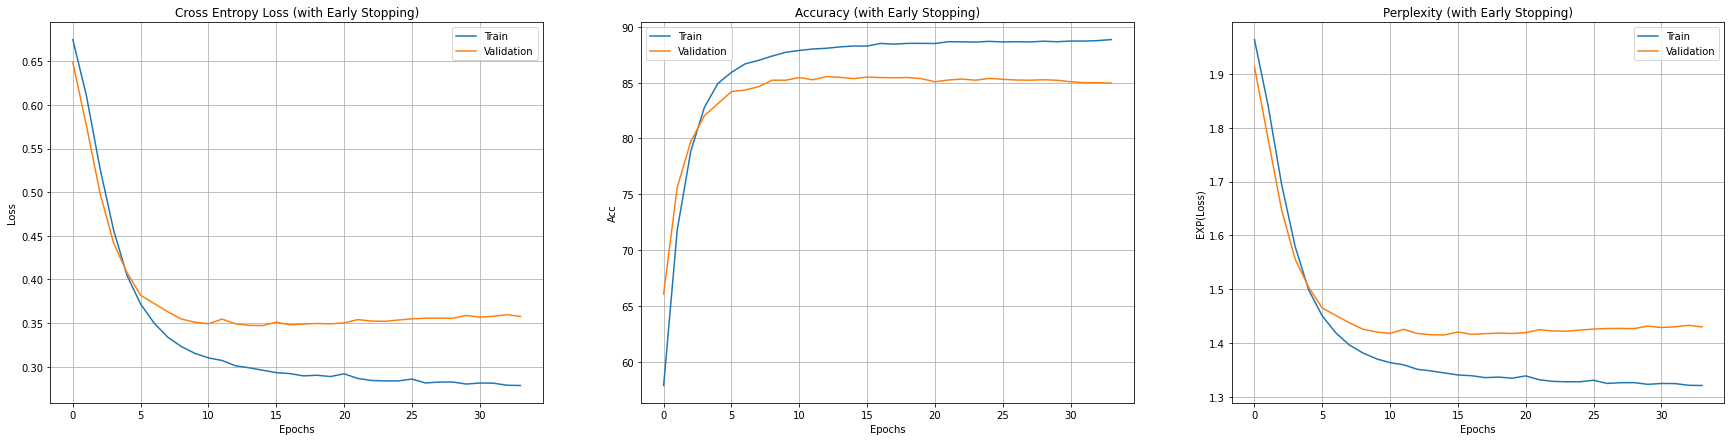

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(len(history['train_loss']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,7))
axes[0].plot(epochs, history['train_loss'], label='Train')
axes[0].plot(epochs, history['val_loss'], label='Validation')
axes[0].set_title('Cross Entropy Loss (with Early Stopping)')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
axes[0].grid(); axes[0].legend()

axes[1].plot(epochs, history['train_acc'], label='Train')
axes[1].plot(epochs, history['val_acc'], label='Validation')
axes[1].set_title('Accuracy (with Early Stopping)')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Acc')
axes[1].grid(); axes[1].legend()

axes[2].plot(epochs, history['train_perplexity'], label='Train')
axes[2].plot(epochs, history['val_perplexity'], label='Validation')
axes[2].set_title('Perplexity (with Early Stopping)')
axes[2].set_xlabel('Epochs'); axes[2].set_ylabel('EXP(Loss)')
axes[2].grid(); axes[2].legend()

plt.show()

## Modelo no conjunto de teste

In [ ]:
model = NeuralNetwork(input_size=params['max_tokens'], hidden_layer=params['hidden_layer'], n_classes=params['n_classes'])
model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

test_loss, test_correct  = evaluate(model=model, 
                                  dataloader=test_loader,
                                  criterion=criterion)

test_loss = test_loss / len(test_loader)
test_acc = test_correct.cpu().item() / len(test_loader.sampler) * 100
test_perplexity = np.exp(test_loss)

print(f'TEST LOSS: {test_loss} ----- TEST ACC: {test_acc} ----- TEST PERPLEXITY: {test_perplexity}')

TEST LOSS: 0.3278947166946469 ----- TEST ACC: 86.48 ----- TEST PERPLEXITY: 1.3880428268594271
